In [1]:
from tensorflow import keras 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.datasets import cifar100
import tensorflow as tf
import numpy as np
from tensorflow.keras import mixed_precision
from matplotlib import pyplot as plt
from tqdm import tqdm
mixed_precision.set_global_policy('mixed_float16')
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
names = [
'apple', # id 0
'fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'keyboard',
'lamp',
'lawnmower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oaktree',
'orange',
'orchid',
'otter',
'palm',
'pear',
'truck',
'pinetree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow',
'wolf',
'woman',
'worm']

In [3]:
(x,y),(x_t,y_t) = cifar100.load_data()

In [4]:
x = x.astype('float32')
x /=255.0
#x = tf.image.resize(x, (67,67))

In [5]:
x_t = x_t.astype('float32')
x_t/=255.0
#x_t = tf.image.resize(x_t,(67,67))

In [6]:
embeddings_index = {}
with open('50d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
name_vecs = []
for i in names:
    name_vecs.append(embeddings_index[i])

In [8]:
new_y = []
for i in y:
    new_y.append(embeddings_index[names[i[0]]])
new_y = np.array(new_y).astype('float32')

In [9]:
new_y_t = []
for i in y_t:
    new_y_t.append(embeddings_index[names[i[0]]])
    
new_y_t = np.array(new_y_t).astype('float32')


In [10]:
def get_model():
    m = Sequential([
        Conv2D(64,(3,3),(1,1),padding='same',activation='relu',input_shape=(32,32,3)),
        Dropout(0.2),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Dropout(0.2),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Dropout(0.2),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Dropout(0.2),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        Conv2D(128,(1,1),(1,1),padding='same',activation='relu'),
        Dropout(0.2),
        Conv2D(128,(1,1),(1,1),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),(1,1),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(256,activation='relu'),
        Dense(256,activation='relu'),
        Dense(50,activation='linear')
    ])
    m.compile(loss='mse',optimizer=tf.optimizers.Nadam(learning_rate=0.0001))
    #print(m.summary())
    return(m)

In [11]:
def get_acc(out):
    ret = []

    for o in range(len(out)):
        low = ['',np.inf]
        for n in range(len(name_vecs)):
            dist = np.linalg.norm(out[o]-name_vecs[n])
            if dist<low[1]:
                low = [n,dist]

        ret.append(low[0])
    return(ret)

In [12]:
res100={}
for j in tqdm(range(100)):
    res100[j]={}
    new_y = []
    new_x = []
    for i in range(len(y)):
        if y[i]!=j:
            new_y.append(embeddings_index[names[y[i][0]]])
            new_x.append(x[i])
    new_y = np.array(new_y).astype('float32')
    new_x = np.array(new_x).astype('float32')
    model=get_model()
    for e in range(25):
        model.fit(new_x,new_y,epochs=1,batch_size=128,verbose=0)
        res100[j][e]=model.predict(x_t)
    tf.keras.backend.clear_session()

100%|██████████| 100/100 [13:18:47<00:00, 479.27s/it] 


In [13]:
1+1

2

In [ ]:
for k in res100.keys():
    for j in res100[k].keys():
        res100[k][j]=res100[k][j].tolist()

In [ ]:
json.dump(res100,open('res100_vecs.json','w'))

In [14]:
import json

In [18]:
test_res = []
for i in range(100):
    test_res.append([])
    for j in range(25):
        t1 = []
        t2 = []
        for y in range(len(y_t)):
            if y_t[y]==i:
                t1.append(res100[i][j][y])
                t2.append(new_y_t[y])
        t1 = np.array(t1)
        t2 = np.array(t2)
        test_res[i].append(np.mean(np.sum((t1-t2)**2,axis=1)))
test_res = np.array(test_res)
test_res.shape

(100, 25)

(15, 20)

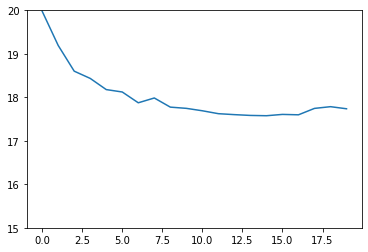

In [28]:
plt.plot(test_res.mean(axis=0)[:20])
plt.ylim(15,20)

In [41]:
import pandas as pd

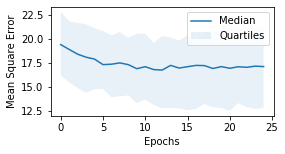

In [59]:
fig,ax = plt.subplots(figsize=(4,2))
ax.plot(np.median(test_res,axis=0),label='Median')
ax.fill_between(np.array([k for k in range(25)]),np.array(low),np.array(high),alpha=0.1,label='Quartiles')
plt.ylabel('Mean Square Error')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('loss.png',dpi=1000)

In [53]:
low = []
high = []
for k in range(25):
    temp = np.sort(test_res[:,k])
    low.append(np.mean(temp[24:26]))
    high.append(np.mean(temp[74:76]))

In [34]:
np.where(test_res[:,24]==np.median(test_res[:,24]))

(array([], dtype=int64),)

In [36]:
change = []
for k in test_res:
    change.append((k[24]/k[0]))

In [61]:
changes = pd.DataFrame(1-np.array(change))

In [65]:
from tensorflow.keras.utils import plot_model

In [130]:
plot_model(model,show_shapes=True,to_file='model.png',dpi=1000)

In [72]:
quant_5, quant_25, quant_50, quant_75, quant_95 = changes.quantile(0.05), changes.quantile(0.25), changes.quantile(0.5), changes.quantile(0.75), changes.quantile(0.95)

quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop






No handles with labels found to put in legend.


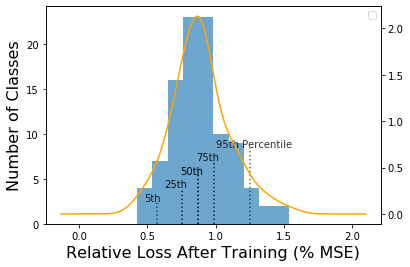

In [129]:
fig, ax = plt.subplots()

changes.hist(ax=ax,alpha=.65,color='C0')
changes.plot.kde(ax=ax,color='orange',secondary_y=True,label=None)

for i in quants:
    ax.vlines(i[0], alpha = i[1], ymin = 0,ymax = 15*i[2], linestyle = ":")
    
ax.text(quant_5-.1, 15*0.17, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 15*0.27, "25th", size = 10, alpha = 0.85)
ax.text(quant_50-.13, 15*0.37, "50th", size = 10, alpha = 1)
ax.text(quant_75-.13, 15*0.47, "75th", size = 10, alpha = 0.85)
ax.text(quant_95-.25, 15*0.57, "95th Percentile", size = 10, alpha =.8)
ax.set_title('')
ax.set_ylabel('Number of Classes',size=16)
ax.set_xlabel('Relative Loss After Training (% MSE)',size=16)
ax.legend()
plt.savefig('hist.png',dpi=1000)

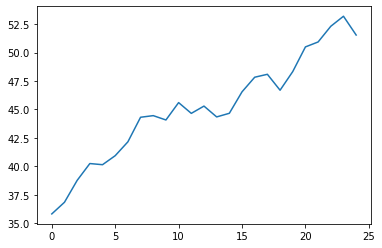

In [33]:
plt.plot(test_res[52])

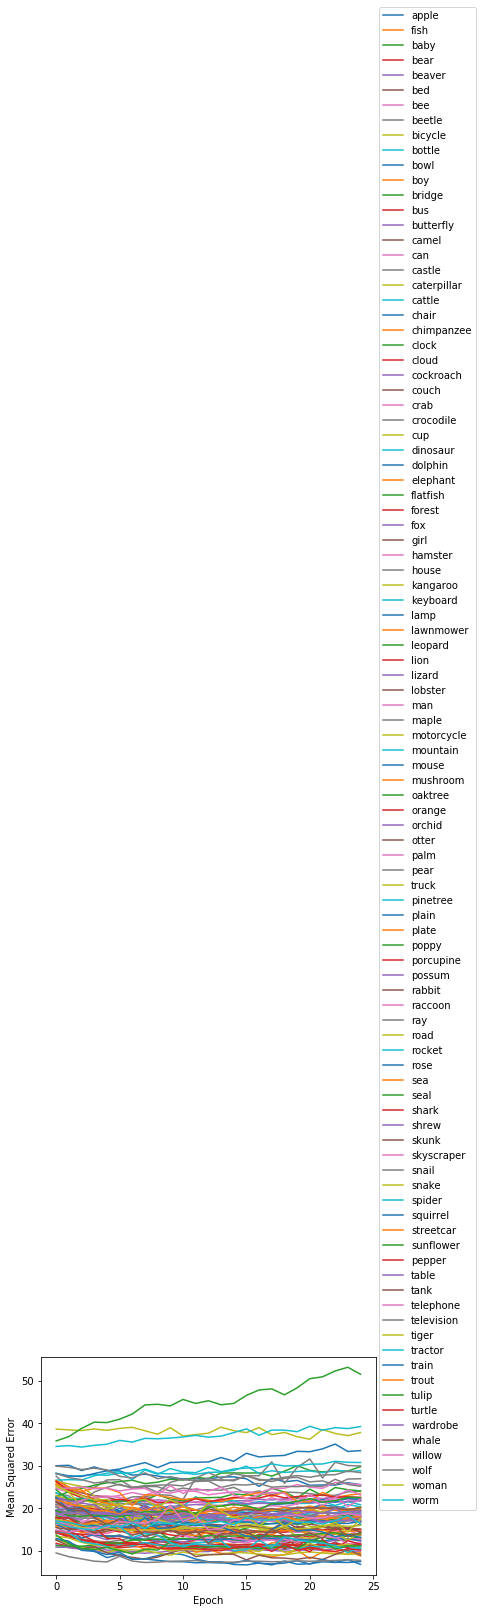

In [20]:
plt.figure()
for f in range(len(test_res)):
    #plt.plot(new_res[f])
    plt.plot(test_res[f],label=str(names[f]))
plt.legend(loc=(1.01,0.3))
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('test_mse',dpi=1000)

In [ ]:
model = get_model()
model.fit(x,new_y,epochs = 200,batch_size = 128)
res = get_acc(model.predict(x_t))


In [ ]:
np.array(res).shape

In [ ]:
np.mean(np.array(res)==y_t.flatten())

In [ ]:
import json
f = open('res.json','r')
res = json.load(f)

In [ ]:
len(res['0']['0'])

In [ ]:
t = get_acc(model.predict(x_t))

In [ ]:
l = model.predict(x_t)
l

In [ ]:
c = []
for i in name_vecs:
    c.append(i.max())
max(c)

In [ ]:
for i in range(10):
    tot=0
    c=0
    for z in range(len(y_t)):
        if y_t[z]==i:
            tot+=1
            if t[z]==i:
                c+=1
            else:
                print(t[z])
    print(c/tot)

In [ ]:
y_t

In [ ]:
new_res = []
for i in range(10):
    new_res.append(np.mean(np.array(res[i][199])==y_t.flatten()))

In [ ]:
new_res

In [ ]:
new_outs


In [ ]:
new_outs = []
for i in range(1,10-1):
    new_outs.append([])
    for j in range(200):
        tot = 0
        c = 0
        
        for y in range(len(y_t)-1):
            if y_t[y]==i-1:
                tot+=1
                if res[i][j][y]==y_t[y]:
                    c+=1
        new_outs[-1].append(c/tot)

In [ ]:
np.array(new_outs).shape

In [ ]:
plt.plot(np.array(new_outs).mean(axis=0))

In [ ]:
plt.figure()
for k in range(len(new_outs)):
    plt.plot(new_outs[k],label=names[k])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('test_acc.png',dpi=1000)

In [ ]:
names= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
tot=0
c=0
for zz in range(len(y_t)):
    if y_t[zz]==0:
        tot+=1
        if res['0']['19'][zz]==0:
            c+=1
c/tot

In [ ]:
for 

In [ ]:
np.mean(np.sum((res1[i][j]-new_y_t)**2,axis=1)/50)**.5

In [ ]:
np.array(zz).tolist()

In [ ]:
new_res = []
for i in range(10):
    new_res.append([])
    for j in range(25):
        new_res[i].append(np.mean(np.sum((res1[i][j]-new_y_t)**2,axis=1)))

In [ ]:
test_res = np.array(test_res)
test_res.shape

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,dpi=1000,to_file='model.png')

In [ ]:
plt.plot(np.mean(test_res,axis=0))

In [ ]:
plt.figure()
for f in range(len(new_res)):
    #plt.plot(new_res[f])
    plt.plot(test_res[f],label=str(names[f]))
plt.legend(loc=(1.01,0.3))
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.savefig('test_mse',dpi=1000)

In [ ]:
res1[0].keys()

In [ ]:
res = []
for o in range(len(out)):
    low = ['',np.inf]
    for n in range(len(name_vecs)):
        dist = np.linalg.norm(out[o]-name_vecs[n])
        if dist<low[1]:
            low = [n,dist]
    res.append(low[0])
    

In [ ]:
tot = 0
c = 0
for y in range(len(y_t)):
    tot+=1
    if y_t[y]==res[y]:
        c+=1
c/tot

In [ ]:
model.save('vector_net_0.1')

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(67,67,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(512, activation='relu'),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(50, activation='linear'),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(512, activation='relu'),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Reshape((1,1,512)),
    keras.layers.UpSampling2D((3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.UpSampling2D((3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    #keras.layers.Dropout(0.25),
    keras.layers.UpSampling2D((3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=96, kernel_size=(7,7), strides=(1,1), activation='relu',padding='valid'),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=(11,11), strides=(4,4), activation='relu'),
    
    
    
    
])
model.compile(loss='mse', optimizer=tf.optimizers.Nadam(learning_rate=0.00005), metrics=['accuracy'])
model.summary()

In [ ]:
l=model.fit(x,x,epochs=720)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(67,67,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(50, activation='linear')
])
model.compile(loss='rmse', optimizer=tf.optimizers.Nadam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()